<a href="https://colab.research.google.com/github/EricDeop/NLP--Spacy-Preprocessing-/blob/PNTA-comments/PNTA_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

import numpy as np
import pandas as pd

path = "/content/drive/MyDrive/LeaderComment.csv"

df = pd.read_csv(path)

df.head()

Mounted at /content/drive


,SURVEYRESPONDERID,AVERAGE_RESPONSE_DATE,YEAR,MONTH,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
0,17296164,1/7/21,2021,1,Male,30013,Melvins professional demeanor and interpersona...
1,17311889,1/7/21,2021,1,Female,30014,Proved better supervision and support.
2,17334983,1/7/21,2021,1,Male,30013,Proven experience
3,17340598,1/2/21,2021,1,Male,30014,"Let the team do what they were hired to do, so..."
4,17340874,1/2/21,2021,1,Male,30013,They consistently look for opportunities to ma...


In [2]:
#Importing necessary packages
import spacy
import re
import string
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

#Data Cleaning before splitting dataset to only male gender

In [3]:
df['GENDER'] = df['GENDER'].str.lower()

df = df.replace({'GENDER' : {'do not wish to disclose' : 'prefer not to answer',
                        'cisgender' : 'gender not listed', 'm' : 'male', 
                        'f' : 'female'}})

df = df[df["GENDER"].str.contains(
    "non-binary|other gender|gender not listed|gender identity not listed|other gender"
    ) == False]

print("\n")

df['GENDER'].value_counts()

female                  96071
male                    84840
prefer not to answer    24326
Name: GENDER, dtype: int64

In [4]:
#Removing duplicates
#Survey responder ID - Duplicate survey ID indicates same person
#cannot ascertain if duplicate comments exist that they are from the same person
#left comments as is and the other columns too

ids = df['SURVEYRESPONDERID']
duplicates = ids[ids.duplicated()]

print("Duplicate ID's :", duplicates.value_counts().sum(),"\n")

df = df.drop_duplicates(subset=['SURVEYRESPONDERID'])
print("Rows, Columns after Duplicate ID's removed: ",df.shape)

Duplicate ID's : 24 

Rows, Columns after Duplicate ID's removed:  (205213, 7)


In [5]:
# Removing Nan Values

print(df.isna().sum().sort_values(ascending = False))

#NaN values only found in comment column
#Removal of those 4 comments
df = df.dropna()

df.shape

# Dropping AVERAGE_RESPONSE_DATE, YEAR, and MONTH columns as they will 
# not be relevant to this analysis

df = df.drop(columns=['AVERAGE_RESPONSE_DATE', 'YEAR', 'MONTH'], axis=1)
df.head()

COMMENT                    4
SURVEYRESPONDERID          0
AVERAGE_RESPONSE_DATE      0
YEAR                       0
MONTH                      0
GENDER                     0
SURVEYQUESTIONESSENCEID    0
dtype: int64


,SURVEYRESPONDERID,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
0,17296164,male,30013,Melvins professional demeanor and interpersona...
1,17311889,female,30014,Proved better supervision and support.
2,17334983,male,30013,Proven experience
3,17340598,male,30014,"Let the team do what they were hired to do, so..."
4,17340874,male,30013,They consistently look for opportunities to ma...


In [6]:
# Converting all text to lowercase and removing punctuations

def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]',' ', text)
  text = re.sub('\[.*?\#]', '', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  return text

cleaning = lambda x: clean_text(x)

In [7]:
df_clean = pd.DataFrame(df['COMMENT'].apply(cleaning))

df["COMMENT"] = df_clean

print(df['COMMENT'].head(10),"\n")
print(df['COMMENT'].tail(10))

0    melvins professional demeanor and interpersona...
1               proved better supervision and support 
2                                   proven experience 
3    let the team do what they were hired to do  so...
4    they consistently look for opportunities to ma...
5    willingness to terminate bad employees  commit...
6    calm  fearless  godliness of character  respec...
7    it doesnt  you have a manager that wife works ...
8    quit pitting the different shifts and departme...
9    pay me what i deserve based on my qualificatio...
Name: COMMENT, dtype: object 

206951               good at communicating what is required
206952                 employ composite industry managers  
206953                        drug test and stick to policy
206954                     passion and drive for results   
206955    spend money in the right areas   stop employin...
206956    his open and willingness to describe what is g...
206957    howard makes sure that we feel safe and feel c...

In [8]:
#Splitting Original data to only prefer not to answer under GENDER column

PNTA = df[df["GENDER"].str.match("prefer not to answer") == True]

PNTA.head()

,SURVEYRESPONDERID,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
7,17341745,prefer not to answer,30013,it doesnt you have a manager that wife works ...
10,17341787,prefer not to answer,30013,when they take the time to truly understand an...
70,17363891,prefer not to answer,30014,talk less listen more
81,17365201,prefer not to answer,30013,great speaker
89,17365445,prefer not to answer,30013,genuine


In [9]:
# Splitting MALE gender by SURVEYQUESTIONESSENCEID

pnta_inspire = PNTA[PNTA["SURVEYQUESTIONESSENCEID"] == 30013]
pnta_gain = PNTA[PNTA["SURVEYQUESTIONESSENCEID"] == 30014]


print(pnta_inspire.iloc[[0,1,2,3,4],[1,2]], "\n")
print(pnta_gain.iloc[[0,1,2,3,4],[1,2]])

                   GENDER  SURVEYQUESTIONESSENCEID
7    prefer not to answer                    30013
10   prefer not to answer                    30013
81   prefer not to answer                    30013
89   prefer not to answer                    30013
165  prefer not to answer                    30013 

                   GENDER  SURVEYQUESTIONESSENCEID
70   prefer not to answer                    30014
96   prefer not to answer                    30014
113  prefer not to answer                    30014
121  prefer not to answer                    30014
125  prefer not to answer                    30014


#TOKENIZATION

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

pnta_inspire_words = list(sent_to_words(pnta_inspire["COMMENT"]))

pnta_gain_words = list(sent_to_words(pnta_gain["COMMENT"]))

print(pnta_inspire_words[:1],"\n")

print(pnta_gain_words[:1])

[['it', 'doesnt', 'you', 'have', 'manager', 'that', 'wife', 'works', 'as', 'regular', 'employee', 'but', 'they', 'can', 'get', 'away', 'with', 'anything']] 

[['talk', 'less', 'listen', 'more']]


#Forming Bigrams in Datasets

In [11]:
#Bigrams

inspire_bigram = gensim.models.Phrases(pnta_inspire_words, min_count=3,threshold=10)

gain_bigram = gensim.models.Phrases(pnta_gain_words, min_count=3,threshold=10)

In [12]:
bigram_mod_inspire = gensim.models.phrases.Phraser(inspire_bigram)

bigram_mod_gain = gensim.models.phrases.Phraser(gain_bigram)

In [13]:
def make_inspire_bigrams(texts):
    return [bigram_mod_inspire[doc] for doc in texts]

def make_gain_bigrams(texts):
    return [bigram_mod_gain[doc] for doc in texts]

female_inspire_words = make_inspire_bigrams(pnta_inspire_words)

female_gain_words = make_gain_bigrams(pnta_gain_words)

In [14]:
print(pnta_inspire_words[0])

print(pnta_gain_words[1])

['it', 'doesnt', 'you', 'have', 'manager', 'that', 'wife', 'works', 'as', 'regular', 'employee', 'but', 'they', 'can', 'get', 'away', 'with', 'anything']
['promote', 'people', 'to', 'positions', 'based', 'on', 'their', 'work', 'to', 'date', 'and', 'their', 'commitment', 'to', 'the', 'company']


In [15]:
print(len(pnta_inspire_words))
print(len(pnta_gain_words))

9221
15097


#Removing Stop Words with manual list added and removal of bigrams from dataset

In [16]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

nlp = spacy.load('en_core_web_lg', disable = ['parser','ner'])

print(nlp.Defaults.stop_words)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
{'myself', "n't", 'when', 'might', 'wherein', 'as', 'should', '‘s', 'get', 'everywhere', 'been', 'wherever', 'see', 'can', 'hereupon', 'against', 'only', 'though', 'put', 'some', 'all', 'used', 'a', 'whatever', 'do', 'ca', 'had', 'indeed', 'two', 'part', 'alone', 'up', 'there', 'no', '‘re', 'amount', 'for', 'much', 'except', 'neither', '’re', 'whole', 'during', 'on', 'make', 'just', 'once', 'onto', 'so', 'really', 'with', 'bottom', 'serious', 'beyond', 'if', 'was', 'again', 'my', 'after', 'former', 'not', 'across', 'call', 'him', 'six', 'seemed', 'say', 'keep', 'fifteen', 'top', 'latter', '’ll', 'nine', 'move', 'will', 'may', 'hundred', 'it', 'their', 'whenever', 'almost', 'out', 'whither', 'least', 'while', 'cannot', 'regarding', 'anyhow', "'m", 'nor', 'either', 'herein', 'whence', 'hence', 'this', 'per', 'sometime', "'s", 'ever', 'who', 'me', 'because', '’m', 'herself', 'i', 'above', 

In [17]:
#Adding my own stop words to list to get a better topic model

nlp.Defaults.stop_words |= {'employees', 'company', 'work', 'people', 'like', 
                            'feel', 'leadership','know', 'time', 'staff', 
                            'better', 'leader', 'good', 'team', 'don','confidence',
                            'great', 'ceo', 'care', 'new', 'job', 'business',
                            'things', 'listen', 'decisions','doesn','u'}

In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in nlp.Defaults.stop_words] for doc in texts]

In [19]:
inspire_words_nostops = remove_stopwords(pnta_inspire_words)

gain_words_nostops = remove_stopwords(pnta_gain_words)

In [20]:
#Making bigrams with data set with not stop words

inspire_nostops_bigrams = make_inspire_bigrams(inspire_words_nostops)

gain_nostops_bigrams = make_gain_bigrams(gain_words_nostops)

In [21]:
print(inspire_nostops_bigrams[0:5],"\n")
      
print(gain_nostops_bigrams[0:5]) 

[['doesnt', 'manager', 'wife', 'works', 'regular', 'employee', 'away'], ['truly', 'understand', 'respect', 'position', 'day', 'day', 'lead', 'mean', 'fully', 'understand', 'position', 'interact', 'different', 'types', 'callers', 'stakeholders'], ['speaker'], ['genuine'], ['numbers', 'meritocracy']] 

[['talk'], ['promote', 'positions', 'based', 'date', 'commitment'], ['actions', 'improve', 'discipline', 'trust', 'teachers'], ['allow', 'timers', 'working', 'hours', 'receive', 'benefits', 'livable', 'wages', 'pandemic'], []]


# Lemmatization

In [22]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ', 'VERB','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

inspire_final_words = lemmatization(inspire_nostops_bigrams, allowed_postags = [
    'NOUN','ADJ', 'VERB','ADV'])

gain_final_words = lemmatization(gain_nostops_bigrams, allowed_postags = [
    'NOUN','ADJ', 'VERB','ADV'])

print(inspire_final_words[:1])
print(gain_final_words[:1])

[['manager', 'wife', 'work', 'regular', 'employee', 'away']]
[['talk']]


#EDA

In [23]:
long_list_inspire = [item for sublist in inspire_final_words for item in sublist]   

long_list_gain = [item for sublist in gain_final_words for item in sublist]   

In [24]:
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def vb_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_vb_adj = lambda pos: pos[:2] == 'VB' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    all_vbs_adj = [word for (word, pos) in pos_tag(tokenized) if is_vb_adj(pos)]
    return ' '.join(all_vbs_adj) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [25]:
long_string_inspire = ' '.join(long_list_inspire)

long_string_gain = ' '.join(long_list_gain)

In [26]:
print(long_string_inspire[:50])

manager wife work regular employee away truly unde


In [27]:
inspire_verbs_adj = vb_adj(long_string_inspire)

inspire_verbs_adj_tokens = word_tokenize(inspire_verbs_adj)

gain_verbs_adj = vb_adj(long_string_gain)

gain_verbs_adj_tokens = word_tokenize(gain_verbs_adj)

In [28]:
print(inspire_verbs_adj_tokens[:4])

['regular', 'understand', 'respect', 'lead']


In [29]:
print(gain_verbs_adj_tokens[:4])

['improve', 'allow', 'receive', 'livable']


In [30]:
print(len(inspire_verbs_adj_tokens))

print(len(gain_verbs_adj_tokens))

20580
59786


In [31]:
from nltk.probability import FreqDist

fd_inspire = FreqDist(inspire_verbs_adj_tokens)

fd_gain = FreqDist(gain_verbs_adj_tokens)

print(fd_inspire.tabulate(50))
print(fd_gain.tabulate(50))

      believe          make          want         think          open            go      positive          good          know        strong          take       genuine          need      pandemic    understand  approachable       willing          come          hard          give     confident        listen          lead          grow    individual         smart          keep        honest      continue          hear       improve        future         clear knowledgeable           see         speak    personable    successful           try           say       succeed         right          sure       current       provide        appear       inspire       amazing        happen     important 
          432           366           328           306           275           267           252           250           248           224           206           193           189           184           180           170           167           163           162           147           134      

Text(0.5, 1.0, "Prefer Not To Answer TOP 50 words\n--Survey Essence ID: 30013--\n Question: 'What about the leader\n of this company\n inspires your confidence?'")

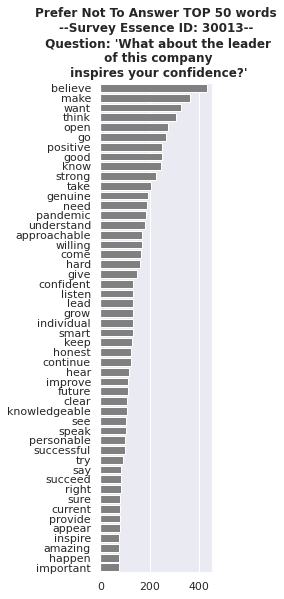

In [32]:
import seaborn as sns
sns.set_theme(style="ticks")
top_inspire = fd_inspire.most_common(50)

fdist_inspire = pd.Series(dict(top_inspire))

sns.set(rc = {'figure.figsize':(2,9)})
pnta_inspire = sns.barplot(y=fdist_inspire.index, x=fdist_inspire.values, color='grey')
pnta_inspire.set_title("Prefer Not To Answer TOP 50 words\n--Survey Essence ID: 30013--\n Question: 'What about the leader\n of this company\n inspires your confidence?'", weight='bold')

Text(0.5, 1.0, "Prefer Not To Answer TOP 50 words\n--Survey Essence ID: 30014--\n Question: 'What could the leader\n of this company do to\n gain your full confidence?'")

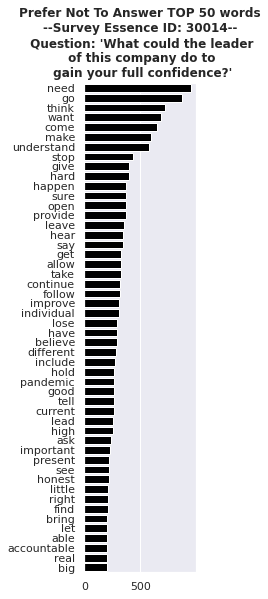

In [33]:
sns.set_theme(style="ticks")
top_gain = fd_gain.most_common(50)

fdist_gain = pd.Series(dict(top_gain))

sns.set(rc = {'figure.figsize':(2,9)})
pnta_gain = sns.barplot(y=fdist_gain.index, x=fdist_gain.values, color='black')
pnta_gain.set_title("Prefer Not To Answer TOP 50 words\n--Survey Essence ID: 30014--\n Question: 'What could the leader\n of this company do to\n gain your full confidence?'",weight='bold')

In [34]:
print(sum(fdist_inspire.values[:50]))
print(sum(fdist_gain.values[:50]))

7802
17216


In [35]:
top_50_inspire = fd_inspire.most_common(50)
top_50_gain = fd_gain.most_common(50)

fdist_50_inspire = pd.Series(dict(top_50_inspire))
fdist_50_gain = pd.Series(dict(top_50_gain))


print(fdist_50_inspire.index[:50])
print(fdist_50_gain.index[:50])

Index(['believe', 'make', 'want', 'think', 'open', 'go', 'positive', 'good',
       'know', 'strong', 'take', 'genuine', 'need', 'pandemic', 'understand',
       'approachable', 'willing', 'come', 'hard', 'give', 'confident',
       'listen', 'lead', 'grow', 'individual', 'smart', 'keep', 'honest',
       'continue', 'hear', 'improve', 'future', 'clear', 'knowledgeable',
       'see', 'speak', 'personable', 'successful', 'try', 'say', 'succeed',
       'right', 'sure', 'current', 'provide', 'appear', 'inspire', 'amazing',
       'happen', 'important'],
      dtype='object')
Index(['need', 'go', 'think', 'want', 'come', 'make', 'understand', 'stop',
       'give', 'hard', 'happen', 'sure', 'open', 'provide', 'leave', 'hear',
       'say', 'get', 'allow', 'take', 'continue', 'follow', 'improve',
       'individual', 'lose', 'have', 'believe', 'different', 'include', 'hold',
       'pandemic', 'good', 'tell', 'current', 'lead', 'high', 'ask',
       'important', 'present', 'see', 'honest'

In [36]:
#Adding words to stop list that are common to both lists

inspire_top_50 = ['believe', 'make', 'want', 'think', 'open', 'go', 'positive', 'good',
       'know', 'strong', 'take', 'genuine', 'need', 'pandemic', 'understand',
       'approachable', 'willing', 'come', 'hard', 'give', 'confident',
       'listen', 'lead', 'grow', 'individual', 'smart', 'keep', 'honest',
       'continue', 'hear', 'improve', 'future', 'clear', 'knowledgeable',
       'see', 'speak', 'personable', 'successful', 'try', 'say', 'succeed',
       'right', 'sure', 'current', 'provide', 'appear', 'inspire', 'amazing',
       'happen', 'important']

gain_top_50 = ['need', 'go', 'think', 'want', 'come', 'make', 'understand', 'stop',
       'give', 'hard', 'happen', 'sure', 'open', 'provide', 'leave', 'hear',
       'say', 'get', 'allow', 'take', 'continue', 'follow', 'improve',
       'individual', 'lose', 'have', 'believe', 'different', 'include', 'hold',
       'pandemic', 'good', 'tell', 'current', 'lead', 'high', 'ask',
       'important', 'present', 'see', 'honest', 'little', 'right', 'find',
       'bring', 'let', 'able', 'accountable', 'real', 'big']

gain_inpspire_common_words = []

for word in inspire_top_50:
  if word in gain_top_50:
    gain_inpspire_common_words.append(word) 

In [37]:
print(gain_inpspire_common_words) 
print(len(gain_inpspire_common_words)) 

#WORDS ADDED TO STOPWORD LIST

['believe', 'make', 'want', 'think', 'open', 'go', 'good', 'take', 'need', 'pandemic', 'understand', 'come', 'hard', 'give', 'lead', 'individual', 'honest', 'continue', 'hear', 'improve', 'see', 'say', 'right', 'sure', 'current', 'provide', 'happen', 'important']
28


In [38]:
nlp.Defaults.stop_words |= {'believe', 'make', 'want', 'think', 'open', 'go', 
                            'good', 'take', 'need', 'pandemic', 'understand', 
                            'come', 'hard', 'give', 'lead', 'individual', 
                            'honest', 'continue', 'hear', 'improve', 'see', 
                            'say', 'right', 'sure', 'current', 'provide', 
                            'happen', 'important','big','happen','look','live','sure',
                            'real','stop','allow','current','little','different',
                            'try','confident','big','try','right','live','current',
                            'sure','run','little','allow','high',
                            'bad','different','start','lead','real',
                            'bring','hold','true','set','different','inspire','hold',
                            'stop','little','follow','high','allow',
                            'real','look','bad','expect','focus','present',
                            'let','find','tell','start','ask','invest','big',
                            'actual','actually'}

In [39]:
#stopwords were still being implemented in model had to remove again

inspire_final_verbs_adj = remove_stopwords(inspire_verbs_adj_tokens)

gain_final_verbs_adj = remove_stopwords(gain_verbs_adj_tokens)

# Creating corpus for Topic Modeling

In [40]:
id2inspire = corpora.Dictionary(inspire_final_verbs_adj)

id2gain = corpora.Dictionary(gain_final_verbs_adj)

inspire_texts = inspire_final_verbs_adj

gain_texts = gain_final_verbs_adj

inspire_corpus = [id2inspire.doc2bow(text) for text in inspire_texts]

gain_corpus = [id2gain.doc2bow(text) for text in gain_texts]

print(inspire_corpus[:1])
print(gain_corpus[:1])

[[(0, 1)]]
[[]]


In [41]:
lda_inspire_model = gensim.models.ldamodel.LdaModel(corpus=inspire_corpus,
                                           id2word=id2inspire,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha='auto',
                                           per_word_topics=True)


lda_gain_model = gensim.models.ldamodel.LdaModel(corpus=gain_corpus,
                                           id2word=id2gain,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha='auto',
                                           per_word_topics=True)

# PNTA topics for those who answered

# **"What about the leader of this company inspires your confidence?"**

In [42]:
pprint(lda_inspire_model.print_topics())
doc_inspire_lda = lda_inspire_model[inspire_corpus]

[(0,
  '0.034*"positive" + 0.030*"strong" + 0.027*"speak" + 0.024*"approachable" + '
  '0.022*"genuine" + 0.018*"willing" + 0.016*"grow" + 0.016*"personable" + '
  '0.011*"available" + 0.009*"successful"'),
 (1,
  '0.023*"knowledgeable" + 0.021*"smart" + 0.014*"future" + 0.013*"friendly" + '
  '0.013*"succeed" + 0.012*"thoughtful" + 0.011*"clear" + 0.011*"handle" + '
  '0.008*"professional" + 0.008*"appreciate"')]


# PNTA topics for those who answered

# **"What could the leader of this company do to gain your full confidence?"**

In [43]:
pprint(lda_gain_model.print_topics())
doc_gain_lda = lda_gain_model[gain_corpus]

[(0,
  '0.016*"leave" + 0.013*"lose" + 0.009*"recognize" + 0.009*"salary" + '
  '0.009*"transparent" + 0.008*"grow" + 0.007*"include" + 0.007*"help" + '
  '0.007*"small" + 0.007*"speak"'),
 (1,
  '0.012*"politic" + 0.011*"learn" + 0.010*"senior" + 0.008*"accountable" + '
  '0.008*"personal" + 0.008*"pay" + 0.007*"spend" + 0.007*"change" + '
  '0.007*"large" + 0.007*"positive"')]


# DATA VISUALIZATIONS

In [44]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 16.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=0b5e805220f1917671f11c9ee996e3540138f966d5bc094104f4afdd0d5b7ff9
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [45]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
inspire_vis = pyLDAvis.gensim_models.prepare(lda_inspire_model, inspire_corpus, id2inspire)
inspire_vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.091006  0.0       1        1  50.800068
1     -0.091006  0.0       2        1  49.199932, topic_info=              Term        Freq       Total Category  logprob  loglift
39        positive  227.000000  227.000000  Default  30.0000  30.0000
3           strong  202.000000  202.000000  Default  29.0000  29.0000
135          speak  186.000000  186.000000  Default  28.0000  28.0000
19    approachable  165.000000  165.000000  Default  27.0000  27.0000
165  knowledgeable  154.000000  154.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
429         entire   32.619352   36.715682   Topic2  -5.2989   0.5910
242      encourage   32.241638   36.767028   Topic2  -5.3105   0.5779
256         engage   41.557912   56.817910   Topic2  -5.0567   0.3965
407      difficult   32.799882   42.579978   Topic2  -5.2933   0.4483
174      necessary   30.731213   48.439361   Topic2  -5.3585   0.2542

[111 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
254       1  0.048933        able
254       2  0.978661        able
270       1  0.701001  accessible
270       2  0.300429  accessible
408       1  0.636637       adapt
...     ...       ...         ...
92        2  0.912067     visible
31        1  0.992870     willing
31        2  0.008072     willing
129       1  0.811157   wonderful
129       2  0.162231   wonderful

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [46]:
gain_vis = pyLDAvis.gensim_models.prepare(lda_gain_model, gain_corpus, id2gain)
gain_vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.046218  0.0       1        1  50.151203
1     -0.046218  0.0       2        1  49.848797, topic_info=              Term        Freq       Total Category  logprob  loglift
102          leave  331.000000  331.000000  Default  30.0000  30.0000
160        politic  247.000000  247.000000  Default  29.0000  29.0000
6            learn  222.000000  222.000000  Default  28.0000  28.0000
76            lose  263.000000  263.000000  Default  27.0000  27.0000
161         senior  204.000000  204.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
332      political   85.240823  138.418547   Topic2  -5.4614   0.2114
309      associate   93.318098  180.297692   Topic2  -5.3709   0.0376
249  understanding   78.466724  125.329853   Topic2  -5.5442   0.2279
486   professional   77.189583  146.890553   Topic2  -5.5606   0.0528
656            low   77.878454  157.405117   Topic2  -5.5518  -0.0075

[116 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
147       1  0.011152         able
147       2  0.992549         able
44        1  0.005977  accountable
44        2  0.992159  accountable
157       1  0.073930          add
...     ...       ...          ...
22        2  0.023472         walk
203       1  0.121786      willing
203       2  0.893100      willing
255       1  0.782199        wrong
255       2  0.210592        wrong

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [47]:
pyLDAvis.save_html(inspire_vis, 'pnta_inspire.html')
pyLDAvis.save_html(gain_vis, 'pnta_gain.html')

#WORD CLOUDS

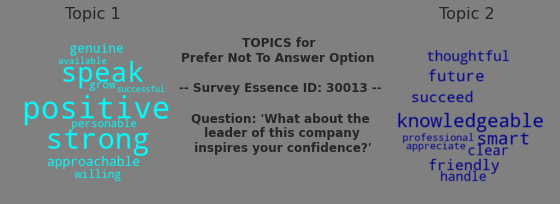

In [48]:
import matplotlib.colors as mcolors
from wordcloud import WordCloud
from PIL import Image


colsi = [color for name, color in mcolors.CSS4_COLORS.items()]

x, y = np.ogrid[:290, :290]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

cloud_inspire = WordCloud(background_color='grey',
                  mask=mask,
                  width=500,
                  height=500,
                  max_words=10,
                  color_func=lambda *args, **kwargs: colsi[i+20],
                  prefer_horizontal=1.0)

topics = lda_inspire_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(16,3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud_inspire.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud_inspire)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

fig.patch.set_facecolor('grey')
fig.suptitle("TOPICS for \nPrefer Not To Answer Option \n\n-- Survey Essence ID: 30013 --\n\nQuestion: 'What about the\n leader of this company\n inspires your confidence?'",
             fontweight='bold',y=0.8,fontsize=12)
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')

plt.imshow(cloud_inspire, interpolation="bilinear")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

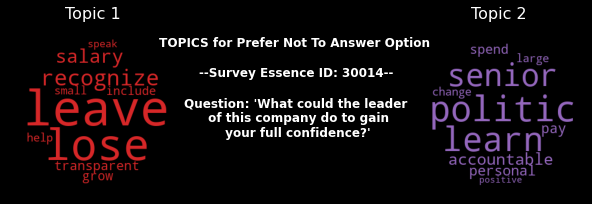

In [49]:
colsd = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud_gain = WordCloud(background_color='black',
                  width=500,
                  height=500,
                  max_words=100,
                  mask=mask,
                  color_func=lambda *args, **kwargs: colsd[i+3],
                  prefer_horizontal=1.0)

topics = lda_gain_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(15,3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud_gain.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud_gain)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16), color='white')
    plt.gca().axis('off')

fig.patch.set_facecolor('black')
fig.suptitle("TOPICS for Prefer Not To Answer Option \n\n--Survey Essence ID: 30014--\n\nQuestion: 'What could the leader\n of this company do to gain\n your full confidence?'",
             fontweight='bold',y=0.8,fontsize=12, color='white')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()